In [24]:
# import os
# import torch
# import torchaudio
# from torch.utils.data import Dataset, DataLoader
# from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
# from torch.optim import AdamW
# import numpy as np
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# from torch.nn.utils.rnn import pad_sequence
# import librosa
# import logging
# import torch.nn as nn
# from transformers import get_scheduler
# from sklearn.utils.class_weight import compute_class_weight


In [25]:
# # Set up logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger(__name__)

# # Constants
# SAMPLE_RATE = 16000
# MIN_DURATION = 0.1
# MAX_DURATION = 10.0
# MIN_AMPLITUDE = 1e-6
# MAX_LENGTH = 16000
# BATCH_SIZE = 8
# NUM_EPOCHS = 15

# # Emotion to integer mapping for CREMA-D
# emotion_map = {
#     "ANG": 0,  # Anger
#     "DIS": 1,  # Disgust
#     "FEA": 2,  # Fear
#     "HAP": 3,  # Happy
#     "NEU": 4,  # Neutral
#     "SAD": 5,  # Sad
# }

# # Validate audio file
# def validate_audio_file(file_path, processor):
#     try:
#         if os.path.getsize(file_path) == 0:
#             raise ValueError("Empty file")
#         waveform, sr = torchaudio.load(file_path)
#         if waveform.numel() == 0:
#             raise ValueError("Empty waveform")
#         duration = waveform.shape[1] / sr
#         if duration < MIN_DURATION or duration > MAX_DURATION:
#             raise ValueError(f"Invalid duration: {duration}s")
#         waveform_np = waveform.squeeze(0).numpy()
#         max_amplitude = np.max(np.abs(waveform_np))
#         mean_amplitude = np.mean(np.abs(waveform_np))
#         if max_amplitude < MIN_AMPLITUDE:
#             raise ValueError(f"Waveform amplitude too low: max={max_amplitude}, mean={mean_amplitude}")
#         inputs = processor(waveform_np, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
#         if inputs.input_values.numel() == 0 or torch.isnan(inputs.input_values).any():
#             raise ValueError(f"Processor returned invalid input: numel={inputs.input_values.numel()}, has_nan={torch.isnan(inputs.input_values).any()}")
#         logger.debug(f"Validated {file_path}: SR={sr}, Duration={duration}s, MaxAmplitude={max_amplitude}, MeanAmplitude={mean_amplitude}")
#         return True
#     except Exception as e:
#         logger.error(f"Validation failed for {file_path}: {str(e)}")
#         return False

# # Extract hand-crafted features using librosa
# def extract_audio_features(file_path):
#     try:
#         y, sr = librosa.load(file_path, sr=None)
#         mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
#         chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
#         contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
#         zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
#         rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
#         features = np.concatenate((mfcc, chroma, contrast, zcr, rms), axis=0)
#         if features.shape[0] != 34:
#             raise ValueError(f"Expected 34 features, got {features.shape[0]}")
#         logger.debug(f"Extracted hand-crafted features for {file_path}: Shape={features.shape}")
#         return features
#     except Exception as e:
#         logger.error(f"Error extracting hand-crafted features for {file_path}: {e}")
#         return np.zeros(34)

# # Extract Wav2Vec2 features
# def extract_wav2vec2_features(file_path, processor, sample_rate=16000, max_length=16000):
#     try:
#         waveform, sr = torchaudio.load(file_path)
#         if waveform.numel() == 0:
#             raise ValueError("Empty waveform")
#         if sr != sample_rate:
#             waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
#         waveform_np = waveform.squeeze(0).numpy()
#         inputs = processor(waveform_np, sampling_rate=sample_rate, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
#         input_values = inputs['input_values'].squeeze(0)
#         attention_mask = inputs['attention_mask'].squeeze(0)
#         if input_values.numel() == 0 or torch.isnan(input_values).any():
#             raise ValueError(f"Processor returned invalid input: numel={input_values.numel()}, has_nan={torch.isnan(inputs.input_values).any()}")
#         logger.debug(f"Extracted Wav2Vec2 features for {file_path}: InputShape={input_values.shape}, MaskShape={attention_mask.shape}")
#         return input_values, attention_mask
#     except Exception as e:
#         logger.error(f"Error extracting Wav2Vec2 features for {file_path}: {e}")
#         return torch.zeros(max_length), torch.zeros(max_length)

# # Custom Dataset
# class CREMADataset(Dataset):
#     def __init__(self, audio_dir, processor, emotion_map, file_paths=None, labels=None, sample_rate=16000):
#         self.audio_dir = audio_dir
#         self.processor = processor
#         self.emotion_map = emotion_map
#         self.sample_rate = sample_rate
#         self.file_paths = file_paths or []
#         self.labels = labels or []
#         self.invalid_files = []

#         if not file_paths or not labels:
#             for file_name in os.listdir(audio_dir):
#                 if file_name.endswith(".wav"):
#                     file_path = os.path.join(audio_dir, file_name)
#                     parts = file_name.split('_')
#                     if len(parts) < 3:
#                         logger.warning(f"Invalid filename format: {file_name}")
#                         continue
#                     emotion = parts[2]
#                     label = self.emotion_map.get(emotion, -1)
#                     if label != -1 and validate_audio_file(file_path, processor):
#                         self.file_paths.append(file_path)
#                         self.labels.append(label)
#                     else:
#                         self.invalid_files.append(file_path)

#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         file_path = os.path.normpath(self.file_paths[idx])
#         label = self.labels[idx]
#         try:
#             wav2vec_features, attention_mask = extract_wav2vec2_features(file_path, self.processor, self.sample_rate, MAX_LENGTH)
#             hand_crafted_features = extract_audio_features(file_path)
#             return {
#                 'input_values': wav2vec_features.clone().detach(),
#                 'attention_mask': attention_mask.clone().detach(),
#                 'labels': torch.tensor(label, dtype=torch.long),
#                 'hand_crafted_features': torch.tensor(hand_crafted_features, dtype=torch.float)
#             }
#         except Exception as e:
#             logger.error(f"Error processing {file_path}: {e}")
#             self.invalid_files.append(file_path)
#             return None

# # Custom Model
# class EmotionRecognitionModel(nn.Module):
#     def __init__(self, wav2vec_model_name="superb/wav2vec2-base-superb-er", num_labels=6):
#         super(EmotionRecognitionModel, self).__init__()
#         self.wav2vec2 = Wav2Vec2ForSequenceClassification.from_pretrained(
#             wav2vec_model_name, num_labels=num_labels, ignore_mismatched_sizes=True, output_hidden_states=True
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(768 + 34, 256),  # 768 from Wav2Vec2 hidden states + 34 from hand-crafted features
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_labels)
#         )

#     def forward(self, input_values, attention_mask, hand_crafted_features):
#         outputs = self.wav2vec2(input_values, attention_mask=attention_mask, output_hidden_states=True)
#         hidden_states = outputs.hidden_states[-1]  # Shape: (batch_size, sequence_length, 768)
#         pooled_features = hidden_states.mean(dim=1)  # Shape: (batch_size, 768)
#         combined_features = torch.cat((pooled_features, hand_crafted_features), dim=1)  # Shape: (batch_size, 768 + 34)
#         logits = self.classifier(combined_features)
#         return logits

# # Load processor and dataset
# processor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")
# audio_dir = "audio-emotion-dataset2"
# dataset = CREMADataset(audio_dir=audio_dir, processor=processor, emotion_map=emotion_map)

# # Split dataset
# train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(
#     dataset.file_paths, dataset.labels, test_size=0.2, random_state=42
# )
# train_dataset = CREMADataset(audio_dir, processor, emotion_map, train_file_paths, train_labels)
# val_dataset = CREMADataset(audio_dir, processor, emotion_map, val_file_paths, val_labels)

# # Filter out None samples
# def filter_dataset(dataset):
#     valid_indices = []
#     valid_data = []
#     for idx in range(len(dataset)):
#         item = dataset[idx]
#         if item is not None:
#             valid_indices.append(idx)
#             valid_data.append(item)
#     if not valid_data:
#         logger.error(f"No valid data after filtering. Invalid files: {dataset.invalid_files}")
#         raise ValueError(f"No valid data after filtering. Check invalid files: {dataset.invalid_files[:10]}...")
#     dataset.file_paths = [dataset.file_paths[i] for i in valid_indices]
#     dataset.labels = [dataset.labels[i] for i in valid_indices]
#     dataset.invalid_files = list(set(dataset.invalid_files))
#     logger.warning(f"Invalid files: {dataset.invalid_files}")
#     return valid_data

# train_dataset = filter_dataset(train_dataset)
# val_dataset = filter_dataset(val_dataset)

# # Create DataLoaders
# def collate_fn(batch):
#     batch = [item for item in batch if item is not None]
#     if not batch:
#         return None
#     input_values = [item['input_values'] for item in batch]
#     attention_mask = [item['attention_mask'] for item in batch]
#     labels = [item['labels'] for item in batch]
#     hand_crafted_features = [item['hand_crafted_features'] for item in batch]
#     input_values = pad_sequence(input_values, batch_first=True, padding_value=0)
#     attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
#     labels = torch.stack(labels, dim=0)
#     hand_crafted_features = torch.stack(hand_crafted_features, dim=0)
#     return {
#         'input_values': input_values,
#         'attention_mask': attention_mask,
#         'labels': labels,
#         'hand_crafted_features': hand_crafted_features
#     }

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [26]:
# from collections import Counter

# label_counts = Counter(train_labels + val_labels)  # or test_labels if available
# print(label_counts)


In [27]:
# import os
# import torch
# import torchaudio
# from torch.utils.data import Dataset, DataLoader
# from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification
# from torch.optim import AdamW
# import numpy as np
# from sklearn.model_selection import train_test_split
# from torch.nn.utils.rnn import pad_sequence
# from tqdm import tqdm
# import librosa
# import logging
# import torch.nn as nn
# from transformers import get_scheduler
# from sklearn.utils.class_weight import compute_class_weight

# # Set up logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# logger = logging.getLogger(__name__)

# # Constants
# SAMPLE_RATE = 16000
# MIN_DURATION = 0.1
# MAX_DURATION = 10.0
# MIN_AMPLITUDE = 1e-6
# MAX_LENGTH = 16000
# BATCH_SIZE = 8
# NUM_EPOCHS = 15

# # Emotion to integer mapping for CREMA-D
# # emotion_map = {
# #     "ANG": 0,  # Anger
# #     "DIS": 1,  # Disgust
# #     "FEA": 2,  # Fear
# #     "HAP": 3,  # Happy
# #     "NEU": 4,  # Neutral
# #     "SAD": 5,  # Sad
# # }

# emotion_map = {'HAP': 0, 'SAD': 1, 'ANG': 2, 'FEA': 3, 'DIS': 4, 'NEU': 5}

# # Validate audio file
# def validate_audio_file(file_path, processor):
#     try:
#         if os.path.getsize(file_path) == 0:
#             raise ValueError("Empty file")
#         waveform, sr = torchaudio.load(file_path)
#         if waveform.numel() == 0:
#             raise ValueError("Empty waveform")
#         duration = waveform.shape[1] / sr
#         if duration < MIN_DURATION or duration > MAX_DURATION:
#             raise ValueError(f"Invalid duration: {duration}s")
#         waveform_np = waveform.squeeze(0).numpy()
#         max_amplitude = np.max(np.abs(waveform_np))
#         mean_amplitude = np.mean(np.abs(waveform_np))
#         if max_amplitude < MIN_AMPLITUDE:
#             raise ValueError(f"Waveform amplitude too low: max={max_amplitude}, mean={mean_amplitude}")
#         inputs = processor(waveform_np, sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
#         if inputs.input_values.numel() == 0 or torch.isnan(inputs.input_values).any():
#             raise ValueError(f"Processor returned invalid input: numel={inputs.input_values.numel()}, has_nan={torch.isnan(inputs.input_values).any()}")
#         logger.debug(f"Validated {file_path}: SR={sr}, Duration={duration}s, MaxAmplitude={max_amplitude}, MeanAmplitude={mean_amplitude}")
#         return True
#     except Exception as e:
#         logger.error(f"Validation failed for {file_path}: {str(e)}")
#         return False

# # Extract hand-crafted features using librosa
# def extract_audio_features(file_path):
#     try:
#         y, sr = librosa.load(file_path, sr=None)
#         mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
#         chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
#         contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
#         zcr = np.mean(librosa.feature.zero_crossing_rate(y).T, axis=0)
#         rms = np.mean(librosa.feature.rms(y=y).T, axis=0)
#         features = np.concatenate((mfcc, chroma, contrast, zcr, rms), axis=0)
#         if features.shape[0] != 34:
#             raise ValueError(f"Expected 34 features, got {features.shape[0]}")
#         logger.debug(f"Extracted hand-crafted features for {file_path}: Shape={features.shape}")
#         return features
#     except Exception as e:
#         logger.error(f"Error extracting hand-crafted features for {file_path}: {e}")
#         return np.zeros(34)

# # Extract Wav2Vec2 features
# def extract_wav2vec2_features(file_path, processor, sample_rate=16000, max_length=16000):
#     try:
#         waveform, sr = torchaudio.load(file_path)
#         if waveform.numel() == 0:
#             raise ValueError("Empty waveform")
#         if sr != sample_rate:
#             waveform = torchaudio.transforms.Resample(sr, sample_rate)(waveform)
#         waveform_np = waveform.squeeze(0).numpy()
#         inputs = processor(waveform_np, sampling_rate=sample_rate, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
#         input_values = inputs['input_values'].squeeze(0)
#         attention_mask = inputs['attention_mask'].squeeze(0)
#         if input_values.numel() == 0 or torch.isnan(input_values).any():
#             raise ValueError(f"Processor returned invalid input: numel={input_values.numel()}, has_nan={torch.isnan(inputs.input_values).any()}")
#         logger.debug(f"Extracted Wav2Vec2 features for {file_path}: InputShape={input_values.shape}, MaskShape={attention_mask.shape}")
#         return input_values, attention_mask
#     except Exception as e:
#         logger.error(f"Error extracting Wav2Vec2 features for {file_path}: {e}")
#         return torch.zeros(max_length), torch.zeros(max_length)

# # Custom Dataset
# class CREMADataset(Dataset):
#     def __init__(self, audio_dir, processor, emotion_map, file_paths=None, labels=None, sample_rate=16000):
#         self.audio_dir = audio_dir
#         self.processor = processor
#         self.emotion_map = emotion_map
#         self.sample_rate = sample_rate
#         self.file_paths = file_paths or []
#         self.labels = labels or []
#         self.invalid_files = []

#         if not file_paths or not labels:
#             for file_name in os.listdir(audio_dir):
#                 if file_name.endswith(".wav"):
#                     file_path = os.path.join(audio_dir, file_name)
#                     parts = file_name.split('_')
#                     if len(parts) < 3:
#                         logger.warning(f"Invalid filename format: {file_name}")
#                         continue
#                     emotion = parts[2]
#                     label = self.emotion_map.get(emotion, -1)
#                     if label != -1 and validate_audio_file(file_path, processor):
#                         self.file_paths.append(file_path)
#                         self.labels.append(label)
#                     else:
#                         self.invalid_files.append(file_path)

#     def __len__(self):
#         return len(self.file_paths)

#     def __getitem__(self, idx):
#         file_path = os.path.normpath(self.file_paths[idx])
#         label = self.labels[idx]
#         try:
#             wav2vec_features, attention_mask = extract_wav2vec2_features(file_path, self.processor, self.sample_rate, MAX_LENGTH)
#             hand_crafted_features = extract_audio_features(file_path)
#             return {
#                 'input_values': wav2vec_features.clone().detach(),
#                 'attention_mask': attention_mask.clone().detach(),
#                 'labels': torch.tensor(label, dtype=torch.long),
#                 'hand_crafted_features': torch.tensor(hand_crafted_features, dtype=torch.float)
#             }
#         except Exception as e:
#             logger.error(f"Error processing {file_path}: {e}")
#             self.invalid_files.append(file_path)
#             return None

# # Custom Model
# class EmotionRecognitionModel(nn.Module):
#     def __init__(self, wav2vec_model_name="superb/wav2vec2-base-superb-er", num_labels=6):
#         super(EmotionRecognitionModel, self).__init__()
#         self.wav2vec2 = Wav2Vec2ForSequenceClassification.from_pretrained(
#             wav2vec_model_name, num_labels=num_labels, ignore_mismatched_sizes=True, output_hidden_states=True
#         )
#         self.classifier = nn.Sequential(
#             nn.Linear(768 + 34, 256),  # 768 from Wav2Vec2 hidden states + 34 from hand-crafted features
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, num_labels)
#         )

#     def forward(self, input_values, attention_mask, hand_crafted_features):
#         outputs = self.wav2vec2(input_values, attention_mask=attention_mask, output_hidden_states=True)
#         hidden_states = outputs.hidden_states[-1]  # Shape: (batch_size, sequence_length, 768)
#         pooled_features = hidden_states.mean(dim=1)  # Shape: (batch_size, 768)
#         combined_features = torch.cat((pooled_features, hand_crafted_features), dim=1)  # Shape: (batch_size, 768 + 34)
#         logits = self.classifier(combined_features)
#         return logits

# # Load processor and dataset
# processor = Wav2Vec2FeatureExtractor.from_pretrained("superb/wav2vec2-base-superb-er")
# audio_dir = "audio-emotion-dataset2"
# dataset = CREMADataset(audio_dir=audio_dir, processor=processor, emotion_map=emotion_map)

# # Split dataset
# train_file_paths, val_file_paths, train_labels, val_labels = train_test_split(
#     dataset.file_paths, dataset.labels, test_size=0.2, random_state=42
# )
# train_dataset = CREMADataset(audio_dir, processor, emotion_map, train_file_paths, train_labels)
# val_dataset = CREMADataset(audio_dir, processor, emotion_map, val_file_paths, val_labels)

# # Filter out None samples
# def filter_dataset(dataset):
#     valid_indices = []
#     valid_data = []
#     for idx in range(len(dataset)):
#         item = dataset[idx]
#         if item is not None:
#             valid_indices.append(idx)
#             valid_data.append(item)
#     if not valid_data:
#         logger.error(f"No valid data after filtering. Invalid files: {dataset.invalid_files}")
#         raise ValueError(f"No valid data after filtering. Check invalid files: {dataset.invalid_files[:10]}...")
#     dataset.file_paths = [dataset.file_paths[i] for i in valid_indices]
#     dataset.labels = [dataset.labels[i] for i in valid_indices]
#     dataset.invalid_files = list(set(dataset.invalid_files))
#     logger.warning(f"Invalid files: {dataset.invalid_files}")
#     return valid_data

# train_dataset = filter_dataset(train_dataset)
# val_dataset = filter_dataset(val_dataset)

# # Create DataLoaders
# def collate_fn(batch):
#     batch = [item for item in batch if item is not None]
#     if not batch:
#         return None
#     input_values = [item['input_values'] for item in batch]
#     attention_mask = [item['attention_mask'] for item in batch]
#     labels = [item['labels'] for item in batch]
#     hand_crafted_features = [item['hand_crafted_features'] for item in batch]
#     input_values = pad_sequence(input_values, batch_first=True, padding_value=0)
#     attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
#     labels = torch.stack(labels, dim=0)
#     hand_crafted_features = torch.stack(hand_crafted_features, dim=0)
#     return {
#         'input_values': input_values,
#         'attention_mask': attention_mask,
#         'labels': labels,
#         'hand_crafted_features': hand_crafted_features
#     }

# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# # Initialize model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = EmotionRecognitionModel(wav2vec_model_name="superb/wav2vec2-base-superb-er", num_labels=len(emotion_map))
# model.to(device)

# # Training setup
# optimizer = AdamW(model.parameters(), lr=1e-5)
# num_training_steps = NUM_EPOCHS * len(train_loader)
# lr_scheduler = get_scheduler(
#     "linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=num_training_steps
# )
# class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# # Training loop
# best_val_accuracy = 0.0
# best_model_path = "wav2vec2_emotion_classifier_best_v3"
# os.makedirs(best_model_path, exist_ok=True)

# for epoch in range(NUM_EPOCHS):
#     model.train()
#     total_loss = 0
#     correct_preds = 0
#     total_preds = 0
#     for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
#         if batch is None:
#             continue
#         batch = {key: value.to(device) for key, value in batch.items()}
#         inputs = batch['input_values']
#         attention_mask = batch['attention_mask']
#         labels = batch['labels']
#         hand_crafted_features = batch['hand_crafted_features']
#         logger.debug(f"Batch shapes: input_values={inputs.shape}, attention_mask={attention_mask.shape}, hand_crafted_features={hand_crafted_features.shape}")
#         optimizer.zero_grad()
#         outputs = model(inputs, attention_mask=attention_mask, hand_crafted_features=hand_crafted_features)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         lr_scheduler.step()
#         total_loss += loss.item()
#         preds = torch.argmax(outputs, dim=-1)
#         correct_preds += (preds == labels).sum().item()
#         total_preds += labels.size(0)
#     train_accuracy = correct_preds / total_preds
#     avg_train_loss = total_loss / len(train_loader)
#     logger.info(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

#     # Validation loop
#     model.eval()
#     val_loss = 0
#     correct_preds = 0
#     total_preds = 0
#     with torch.no_grad():
#         for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
#             if batch is None:
#                 continue
#             batch = {key: value.to(device) for key, value in batch.items()}
#             inputs = batch['input_values']
#             attention_mask = batch['attention_mask']
#             labels = batch['labels']
#             hand_crafted_features = batch['hand_crafted_features']
#             outputs = model(inputs, attention_mask=attention_mask, hand_crafted_features=hand_crafted_features)
#             loss = loss_fn(outputs, labels)
#             val_loss += loss.item()
#             preds = torch.argmax(outputs, dim=-1)
#             correct_preds += (preds == labels).sum().item()
#             total_preds += labels.size(0)
#     val_accuracy = correct_preds / total_preds
#     avg_val_loss = val_loss / len(val_loader)
#     logger.info(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

#     # Save best model
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         torch.save(model.state_dict(), os.path.join(best_model_path, "model.pt"))
#         processor.save_pretrained(best_model_path)
#         logger.info(f"Saved best model at epoch {epoch+1} with val accuracy: {val_accuracy:.4f}")

# # Predict emotion for a single file
# def predict_emotion(file_path, model, processor):
#     model.eval()
#     try:
#         wav2vec_features, attention_mask = extract_wav2vec2_features(file_path, processor, SAMPLE_RATE, MAX_LENGTH)
#         hand_crafted_features = extract_audio_features(file_path)
#         inputs = {
#             'input_values': wav2vec_features.unsqueeze(0).to(device),
#             'attention_mask': attention_mask.unsqueeze(0).to(device),
#             'hand_crafted_features': torch.tensor(hand_crafted_features, dtype=torch.float).unsqueeze(0).to(device)
#         }
#         with torch.no_grad():
#             outputs = model(**inputs)
#             pred = torch.argmax(outputs, dim=-1).item()
#         return {v: k for k, v in emotion_map.items()}[pred]
#     except Exception as e:
#         logger.error(f"Error predicting {file_path}: {e}")
#         return None

# # Test prediction
# sample_file = os.path.join(audio_dir, "1001_DFA_ANG_XX.wav")
# logger.info(f"Predicted emotion for {sample_file}: {predict_emotion(sample_file, model, processor)}")

In [ ]:
import os
import torch
import torchaudio
import numpy as np
import librosa
import logging
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
from torch import nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Constants
SAMPLE_RATE = 16000
MAX_LENGTH = SAMPLE_RATE * 10  # 10 seconds
BATCH_SIZE = 8
NUM_EPOCHS = 15
LEARNING_RATE = 1e-5

# Emotion mapping
emotion_map = {'HAP': 0, 'SAD': 1, 'ANG': 2, 'FEA': 3, 'DIS': 4, 'NEU': 5}

# Feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")

# Dataset class
class CREMADataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load and preprocess audio
        waveform, sr = torchaudio.load(file_path)
        if sr != SAMPLE_RATE:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)
            waveform = resampler(waveform)
        waveform = waveform.squeeze(0)

        # Extract features
        inputs = feature_extractor(waveform.numpy(), sampling_rate=SAMPLE_RATE, return_tensors="pt", padding=True)
        input_values = inputs.input_values.squeeze(0)

        return {
            'input_values': input_values,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Model definition
class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_labels):
        super(EmotionRecognitionModel, self).__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec2.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state
        pooled_output = hidden_states.mean(dim=1)
        logits = self.classifier(pooled_output)
        return logits

# Load data
audio_dir = "audio-emotion-dataset2"
file_paths = []
labels = []
for file_name in os.listdir(audio_dir):
    if file_name.endswith(".wav"):
        parts = file_name.split('_')
        if len(parts) >= 3:
            emotion = parts[2]
            if emotion in emotion_map:
                file_paths.append(os.path.join(audio_dir, file_name))
                labels.append(emotion_map[emotion])

# Split data
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Create datasets and dataloaders
train_dataset = CREMADataset(train_paths, train_labels)
val_dataset = CREMADataset(val_paths, val_labels)

def collate_fn(batch):
    input_values = [item['input_values'] for item in batch]
    labels = [item['labels'] for item in batch]
    input_values = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True)
    labels = torch.stack(labels)
    return {'input_values': input_values, 'labels': labels}

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionRecognitionModel(num_labels=len(emotion_map))
model.to(device)

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
best_val_accuracy = 0.0
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_values)
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    avg_loss = total_loss / len(train_loader)
    logger.info(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Train Accuracy={train_accuracy:.4f}")

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_values = batch['input_values'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_values)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_accuracy = val_correct / val_total
    logger.info(f"Epoch {epoch+1}: Validation Accuracy={val_accuracy:.4f}")
    logger.info("Classification Report:")
    logger.info("\n" + classification_report(all_labels, all_preds, target_names=emotion_map.keys()))

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # torch.save(model.state_dict(), "Wav2Vec2/best_model.pt")
        logger.info(f"Saved best model at epoch {epoch+1} with validation accuracy: {val_accuracy:.4f}")


c:\Users\Asus\anaconda3\envs\my_env\Lib\site-packages\transformers\configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Epoch 1/15:   0%|          | 2/744 [00:15<1:33:48,  7.59s/it]


KeyboardInterrupt: 

In [ ]:
import torch

# Load the entire model directly
# model = torch.load('Wav2Vec2/best_model.pt')

# Save model and weights
model_name = 'Wav2Vec2_Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'Wav2Vec2')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("Wav2Vec2/Wav2Vec2_model_json.json", "w") as json_file:
    json_file.write(model_json)

AttributeError: 'EmotionRecognitionModel' object has no attribute 'save'

In [ ]:
# loading json and model architecture 
json_file = open('Wav2Vec2/Wav2Vec2_model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("Wav2Vec2/Wav2Vec2_Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
# loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# score = loaded_model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
# Custom Model
class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_labels):
        super(EmotionRecognitionModel, self).__init__()
        self.wav2vec2 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base")
        self.classifier = nn.Sequential(
            nn.Linear(self.wav2vec2.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_values):
        outputs = self.wav2vec2(input_values)
        hidden_states = outputs.last_hidden_state
        pooled_output = hidden_states.mean(dim=1)
        logits = self.classifier(pooled_output)
        return logits

emotion_map = {'HAP': 0, 'SAD': 1, 'ANG': 2, 'FEA': 3, 'DIS': 4, 'NEU': 5}

    
from transformers import Wav2Vec2ForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# First load the model architecture (config will be default or custom if you have config.json)
model = EmotionRecognitionModel(num_labels=len(emotion_map))
# Load weights
model.load_state_dict(torch.load("Wav2Vec2/best_model_v1.pt"))
model.to(device)
model.eval()


c:\Users\Asus\anaconda3\envs\my_env\Lib\site-packages\transformers\configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_15260\2884683402.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be a

EmotionRecognitionModel(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    

In [ ]:
import json
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

# Inference loop
true_labels = []
pred_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_values=input_values)
        predictions = torch.argmax(logits, dim=-1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())

# Metrics
accuracy = accuracy_score(true_labels, pred_labels)
report = classification_report(true_labels, pred_labels, target_names=emotion_map.keys(), output_dict=True)
cm = confusion_matrix(true_labels, pred_labels)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Build result dictionary
wav2vec_results = {
    "accuracy": accuracy * 100,
    "precision_macro": report["macro avg"]["precision"] * 100,
    "recall_macro": report["macro avg"]["recall"] * 100,
    "f1_macro": report["macro avg"]["f1-score"] * 100,
    "per_class_accuracy": {
        f"Class {i} ({list(emotion_map.keys())[i]})": float(acc * 100)
        for i, acc in enumerate(per_class_accuracy)
    },
    "confusion_matrix": cm.tolist()
}

# Save to JSON file
json_path = "evaluation_results.json"
if os.path.exists(json_path):
    with open(json_path, "r") as f:
        all_results = json.load(f)
else:
    all_results = {}

all_results["wav2vec2"] = wav2vec_results

with open(json_path, "w") as f:
    json.dump(all_results, f, indent=4)

print(f"✅ Wav2Vec2 evaluation saved under key 'wav2vec2' in {json_path}")

# Accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
# best  Validation Accuracy: 78.11%

✅ Wav2Vec2 evaluation saved under key 'wav2vec2' in evaluation_results.json
Validation Accuracy: 78.11%


In [29]:
from sklearn.metrics import f1_score

val_f1 = f1_score(true_labels, pred_labels, average="weighted")
val_f1

0.7779164489960447

In [30]:
labels = [label for label, idx in sorted(emotion_map.items(), key=lambda x: x[1])]

from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, target_names=labels))

              precision    recall  f1-score   support

         HAP       0.82      0.81      0.81       259
         SAD       0.78      0.59      0.67       269
         ANG       0.84      0.93      0.88       237
         FEA       0.73      0.76      0.74       246
         DIS       0.79      0.76      0.78       268
         NEU       0.73      0.87      0.79       210

    accuracy                           0.78      1489
   macro avg       0.78      0.79      0.78      1489
weighted avg       0.78      0.78      0.78      1489



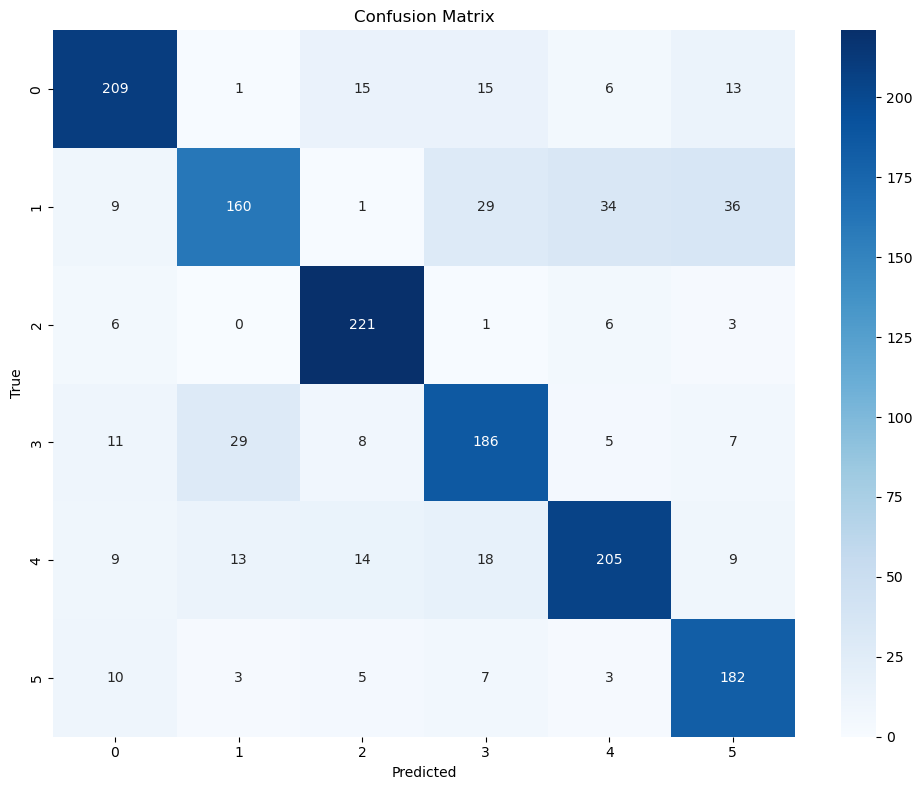

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
labels = list(emotion_map.values()) 

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
from torch.utils.data import DataLoader
import numpy as np

# Evaluation on the validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_values = batch['input_values'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_values)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted'
)

# Print results
print(f"\n📊 Evaluation Metrics on Validation Set:")
print(f"✅ Accuracy:  {accuracy:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🔁 Recall:    {recall:.4f}")
print(f"🧠 F1 Score:  {f1:.4f}")

# Detailed per-class breakdown
print("\n🔍 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=emotion_map.keys()))

c:\Users\Asus\anaconda3\envs\my_env\Lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📊 Evaluation Metrics on Validation Set:
✅ Accuracy:  0.1672
🎯 Precision: 0.3975
🔁 Recall:    0.1672
🧠 F1 Score:  0.1087

🔍 Classification Report:
              precision    recall  f1-score   support

         HAP       0.16      0.12      0.14       259
         SAD       0.65      0.05      0.09       269
         ANG       0.24      0.04      0.07       237
         FEA       1.00      0.00      0.01       246
         DIS       0.14      0.08      0.10       268
         NEU       0.16      0.82      0.27       210

    accuracy                           0.17      1489
   macro avg       0.39      0.19      0.11      1489
weighted avg       0.40      0.17      0.11      1489

